In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from transformers import EfficientNetImageProcessor, EfficientNetForImageClassification, get_scheduler
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sns

# Check and create output directory
if not os.path.exists('./outputs'):
    os.mkdir('./outputs')

c:\Users\thanh-dung.le\.conda\envs\efficientViT\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Check if a GPU is available
print(f"Is GPU available? {torch.cuda.is_available()}")

# Check the name of the GPU being used
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")


Is GPU available? True
GPU Name: NVIDIA RTX A5000 Laptop GPU


In [3]:
# Print the total, allocated, and cached memory on the GPU
if torch.cuda.is_available():
    print(f"Total GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"Allocated Memory: {torch.cuda.memory_allocated(0) / 1e6:.2f} MB")
    print(f"Cached Memory: {torch.cuda.memory_reserved(0) / 1e6:.2f} MB")


Total GPU Memory: 17.18 GB
Allocated Memory: 0.00 MB
Cached Memory: 0.00 MB


In [4]:
!nvidia-smi

Wed Oct 16 11:14:17 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 552.74                 Driver Version: 552.74         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A5000 Laptop GPU  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   53C    P0             30W /  115W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
# Global parameters
USE_CUDA = torch.cuda.is_available()
DATASET_PATH = 'C:\\Users\\thanh-dung.le\\Documents\\EuroSat_Satellite\\EuroSAT_RGB'
BATCH_SIZE = 64
NUM_EPOCHS = 25
LEARNING_RATE = 0.001
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0005

In [6]:

# Check train and test directories
train_path = os.path.join(DATASET_PATH, 'train')
print(f"Train directory exists: {os.path.exists(train_path)}")
print(f"Classes in train directory: {os.listdir(train_path)}")
test_path = os.path.join(DATASET_PATH, 'test')
print(f"Test directory exists: {os.path.exists(test_path)}")
print(f"Classes in test directory: {os.listdir(test_path)}")

# Data transformations
data_transforms = transforms.Compose([
    transforms.Resize(224),  # Resizing to 256 as required by EfficientNet
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Datasets and DataLoaders
train_dataset = datasets.ImageFolder(os.path.join(DATASET_PATH, 'train'), data_transforms)
train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_dataset = datasets.ImageFolder(os.path.join(DATASET_PATH, 'test'), data_transforms)
test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
class_names = train_dataset.classes

print('Dataloaders OK')

Train directory exists: True
Classes in train directory: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Test directory exists: True
Classes in test directory: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Dataloaders OK


Image label: 6


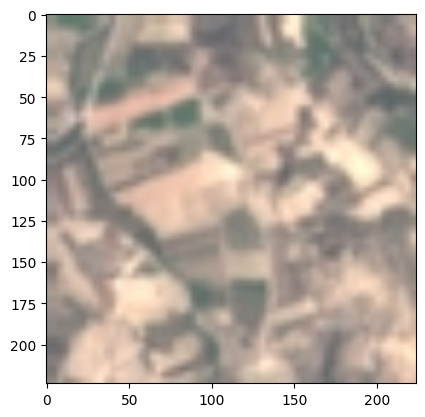

In [7]:
# Example data point visualization
random_image = train_dataset[13421][0].numpy().transpose((1, 2, 0))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
random_image = std * random_image + mean
random_image = np.clip(random_image, 0, 1)
print("Image label:", train_dataset[13421][1])
plt.imshow(random_image)
plt.show()

In [8]:
# Load pre-trained model (Google)
from classification.model.build import EfficientViT_M2
model = EfficientViT_M2(pretrained='efficientvit_m2')

# Modify the classifier to match the number of classes
model.head.l = nn.Linear(model.head.l.in_features, len(class_names))


if USE_CUDA:
    model = model.cuda()

print('Network OK')

Network OK


In [9]:
# Simplified summary printing function
def print_model_summary(model):
    print(model)
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("\nTotal parameters:", total_params)
    print("Trainable parameters:", trainable_params)
    print("Non-trainable parameters:", total_params - trainable_params)

In [10]:
from torchsummary import summary
from collections import OrderedDict
print_model_summary(model)

EfficientViT(
  (patch_embed): Sequential(
    (0): Conv2d_BN(
      (c): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ReLU()
    (2): Conv2d_BN(
      (c): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): ReLU()
    (4): Conv2d_BN(
      (c): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (5): ReLU()
    (6): Conv2d_BN(
      (c): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (blocks1): Sequential(
    (0): EfficientViTBlock(
      (dw0): Residual(


In [11]:
# Define the path where the entire model will be saved
model_path = './outputs/EfficientViT_M2.pth'

In [12]:
# Load pre-trained model for inference
from classification.model.build import EfficientViT_M2
loaded_model = EfficientViT_M2(pretrained='efficientvit_m2')

# Modify the classifier to match the number of classes
loaded_model.head.l = nn.Linear(loaded_model.head.l.in_features, len(class_names))



# Load the state dictionary
loaded_model.load_state_dict(torch.load(model_path))

if USE_CUDA:
    loaded_model = loaded_model.cuda()

print('Model loaded and ready for inference')

Model loaded and ready for inference


C:\Users\thanh-dung.le\AppData\Local\Temp\ipykernel_15716\2011106559.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(model_path)

In [13]:
# Criterion, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(loaded_model.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999), eps=1e-08, weight_decay=WEIGHT_DECAY)
#optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
#scheduler = get_scheduler("step", optimizer=optimizer, step_size=7, gamma=0.1)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


Running inference iteration 1/5...

Running inference iteration 2/5...

Running inference iteration 3/5...

Running inference iteration 4/5...

Running inference iteration 5/5...

Run 1 results: Loss=0.03879078089577644 | Accuracy=98.76390605686032 | Precision=0.9876797819943823 | Recall=0.9876390605686032
Inference Time: 18.37 seconds | Average GPU Power Consumption: 30.96 Watts

Run 2 results: Loss=0.03879078089577644 | Accuracy=98.76390605686032 | Precision=0.9876797819943823 | Recall=0.9876390605686032
Inference Time: 19.76 seconds | Average GPU Power Consumption: 28.69 Watts

Run 3 results: Loss=0.03879078089577644 | Accuracy=98.76390605686032 | Precision=0.9876797819943823 | Recall=0.9876390605686032
Inference Time: 19.18 seconds | Average GPU Power Consumption: 28.66 Watts

Run 4 results: Loss=0.03879078089577644 | Accuracy=98.76390605686032 | Precision=0.9876797819943823 | Recall=0.9876390605686032
Inference Time: 19.78 seconds | Average GPU Power Consumption: 28.34 Watts

Run

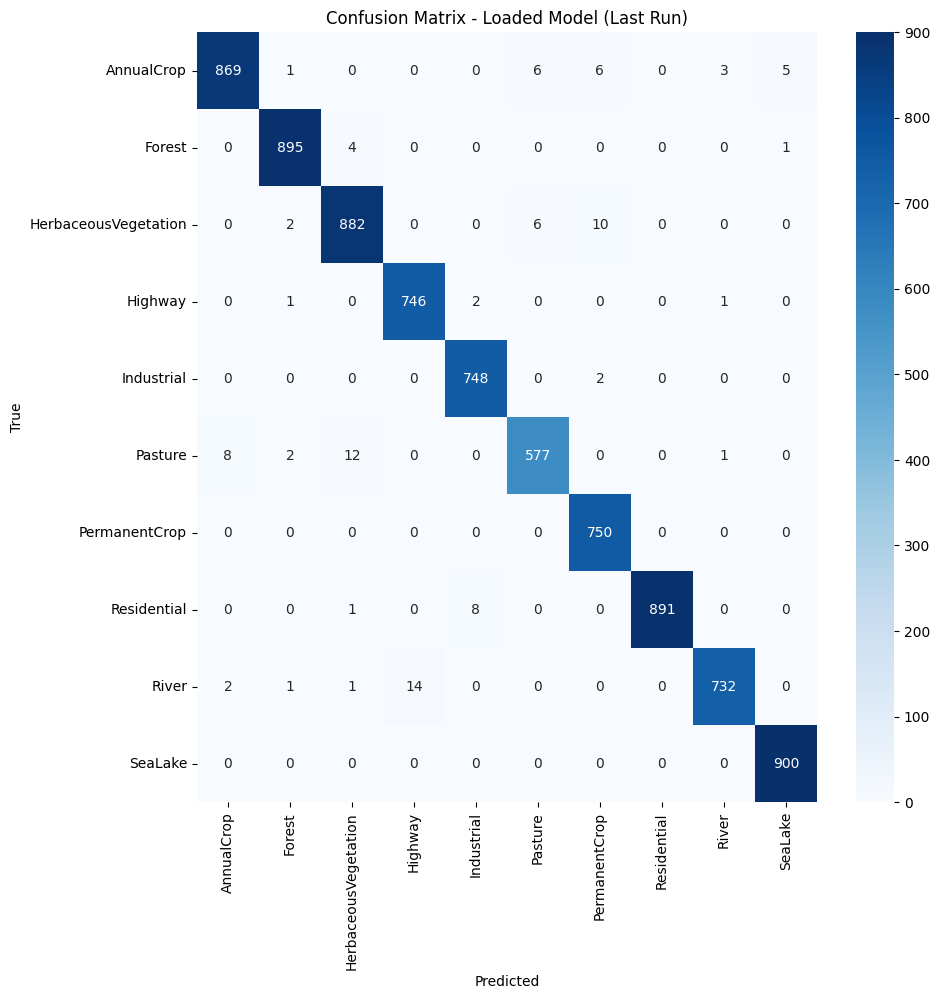

In [14]:
import subprocess
import time
import torch
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats

# Function to measure GPU power consumption using nvidia-smi
def get_gpu_power():
    try:
        # Run nvidia-smi command and capture the output
        result = subprocess.check_output(
            ['nvidia-smi', '--query-gpu=power.draw', '--format=csv,nounits,noheader'],
            encoding='utf-8'
        )
        power_draw = float(result.strip())  # Extract power usage in watts
        return power_draw
    except Exception as e:
        print(f"Error in getting GPU power: {e}")
        return 0.0  # Return 0 if there's an error

# Function to calculate mean and standard deviation
def calculate_mean_std(data):
    mean = np.mean(data)
    std = np.std(data)
    return mean, std

# Function to monitor GPU power consumption during inference
def monitor_inference_with_power(model, test_loader, criterion):
    model.eval()  # Put the network into evaluation mode
    correct = 0
    iterations = 0
    testing_loss = 0.0
    all_preds = []
    all_labels = []

    # Timing for inference of the loaded model
    start_time = time.time()
    power_consumptions = []  # To store power readings

    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in test_loader:
            if USE_CUDA:
                inputs = inputs.cuda()
                labels = labels.cuda()

            # Measure GPU power before processing the batch
            power_consumptions.append(get_gpu_power())

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            testing_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            iterations += 1

    # End timing for inference of the loaded model
    end_time = time.time()
    inference_time = end_time - start_time

    # Calculate average power consumption during inference
    avg_power_consumption = sum(power_consumptions) / len(power_consumptions) if power_consumptions else 0.0

    return testing_loss, correct, iterations, inference_time, avg_power_consumption, all_preds, all_labels

# Run inference 5 times and store results
num_runs = 5
avg_power_consumptions = []
all_results = []

for run in range(num_runs):
    print(f"\nRunning inference iteration {run + 1}/{num_runs}...")
    test_loss, correct, iterations, inference_time, avg_power_consumption, all_preds, all_labels = monitor_inference_with_power(
        loaded_model, test_loader, criterion
    )
    
    test_loss /= iterations
    test_accuracy = 100.0 * correct / len(test_dataset)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')

    # Store average power consumption for this run
    avg_power_consumptions.append(avg_power_consumption)
    
    # Store results for this run
    all_results.append({
        'loss': test_loss,
        'accuracy': test_accuracy,
        'precision': precision,
        'recall': recall,
        'inference_time': inference_time,
        'avg_power_consumption': avg_power_consumption
    })

# Calculate mean and standard deviation for average power consumption
mean_power, std_power = calculate_mean_std(avg_power_consumptions)

# Output final results
for i, result in enumerate(all_results):
    print(f"\nRun {i + 1} results: Loss={result['loss']} | Accuracy={result['accuracy']} | Precision={result['precision']} | Recall={result['recall']}")
    print(f"Inference Time: {result['inference_time']:.2f} seconds | Average GPU Power Consumption: {result['avg_power_consumption']:.2f} Watts")

print(f"\nAverage GPU Power Consumption: {mean_power:.2f} ± {std_power:.2f} Watts")

# Confusion matrix for the last run
conf_matrix_final = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix_final, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Loaded Model (Last Run)')
plt.show()